# Two thirds of the average game

## History of play of actual game

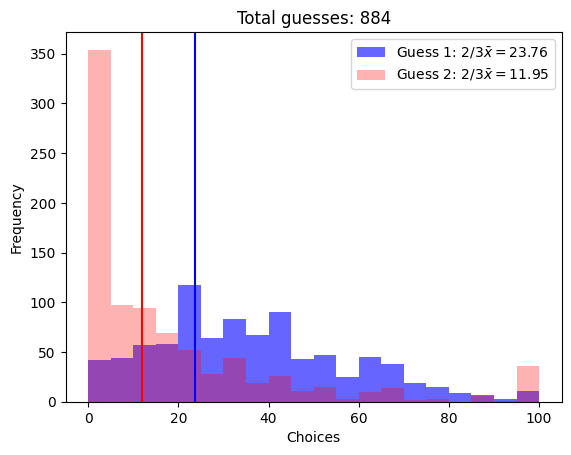

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv")


plt.figure()

two_thirds_mean_first_guess = 2 * df["Guess 1"].mean() / 3
two_thirds_mean_second_guess = 2 * df["Guess 2"].mean() / 3

plt.hist(
    df["Guess 1"], 
    bins=20, 
    alpha=.6, 
    label=f"Guess 1: $2/3\\bar x = {two_thirds_mean_first_guess:.02f}$", 
    color="blue",
)
plt.axvline(two_thirds_mean_first_guess, color="blue")

plt.hist(
    df["Guess 2"], 
    bins=20, 
    alpha=.3, 
    label=f"Guess 2: $2/3\\bar x = {two_thirds_mean_second_guess:.02f}$", 
    color="red",
)
plt.axvline(two_thirds_mean_second_guess, color="red")
plt.legend()

plt.title(f"Total guesses: {len(df.index)}")
plt.xlabel("Choices")
plt.ylabel("Frequency")

plt.savefig("main.pdf")


## Question

Is this two step convergence indicative of what will happen?

## Replicator dynamics

The following fitness function makes sense:

$$
    f_i(x) = \frac{1}{1 + \left(i - \frac{2}{3}\sum_{i=0}^{N}ix_i\right) ^ 2}
$$

In [3]:
import numpy as np
import scipy.integrate

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'})

def get_uniform_population(N=101):
    """
    Obtain a uniform population distribution for a given population size.
    """
    return np.ones(N) / (N)

In [4]:
assert np.array_equal(get_uniform_population(N=2), np.array((1, 1)) / 2)
assert np.array_equal(get_uniform_population(), np.ones(101) / 101)

In [5]:
def get_distance_from_two_thirds(x):
    """
    Obtain the distance (for the metric equivalent to the objective function)
    for a given vector x to 2/3rds of the mean of x.
    """
    N = len(x)
    indices = np.arange(0, N)

    return (indices - 2/3 * np.sum(indices * x)) ** 2

In [6]:
x = np.array((1/3, 1/3, 1/3))
assert np.allclose(get_distance_from_two_thirds(x), np.array([0.44444444, 0.11111111, 1.77777778]))

In [7]:
def get_fitness(x):            
    """
    Return the fitness vector f_i
    """
    return 1 / (1 + get_distance_from_two_thirds(x=x))

In [8]:
x = np.array((1/3, 1/3, 1/3))
assert np.allclose(get_fitness(x), np.array([0.69230769, 0.9       , 0.36      ]))

In [9]:
def get_derivative(x, t):
    """
    Return the derivative as defined by the replicator dynamics equation.
    """
    fitness = get_fitness(x=x)
    phi = np.sum(x * fitness)

    return x * (fitness - phi)


A plot of the behaviour with a uniform initial population:

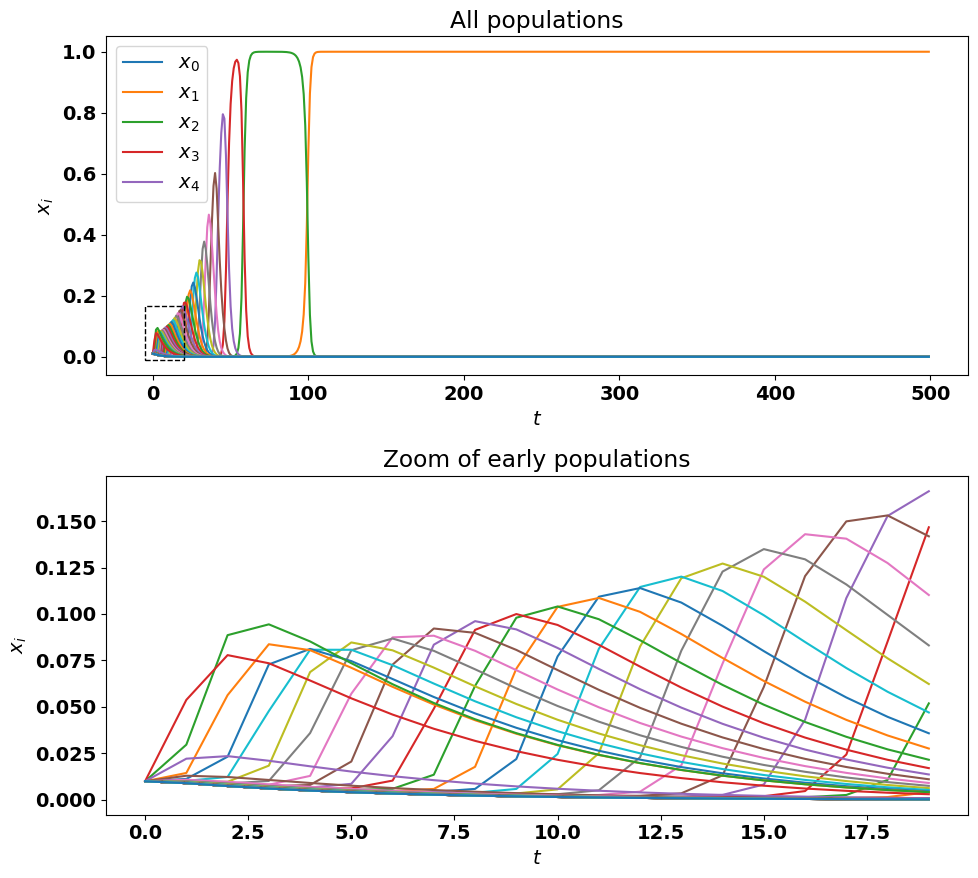

In [10]:
ts = np.linspace(0, 1_000, 500)
x = get_uniform_population(N=101)
xs = scipy.integrate.odeint(func=get_derivative, y0=x, t=ts)

zoom = 20
number_of_labelled_strategies = 5
zoom_box_width_offset = 5
zoom_box_height_offset = 0.01

fig, (ax_2, ax_1) = plt.subplots(nrows=2, figsize=(10, 9))
for i, x in enumerate(xs.T):
    if i < number_of_labelled_strategies:
        ax_1.plot(x[:zoom], label=f"$x_{{{i}}}$")
        ax_2.plot(x, label=f"$x_{{{i}}}$")
    else:
        ax_1.plot(x[:zoom])
        ax_2.plot(x)

ax_1.set_xlabel("$t$")
ax_2.set_xlabel("$t$")
ax_1.set_ylabel("$x_i$")
ax_2.set_ylabel("$x_i$")

ax_1.set_title("Zoom of early populations")
ax_2.set_title("All populations")

ax_2.add_patch(
    patches.Rectangle(
        xy=(-zoom_box_width_offset, -zoom_box_height_offset), 
        width=zoom + zoom_box_width_offset,
        height=xs[:zoom].max() + zoom_box_height_offset, 
        fc='none', 
        color="black", 
        linewidth=1, 
        linestyle="dashed",
        zorder=2,
    )
)
ax_2.legend()
fig.tight_layout()
fig.savefig("main.pdf", transparent=True)

## Effect of the starting population

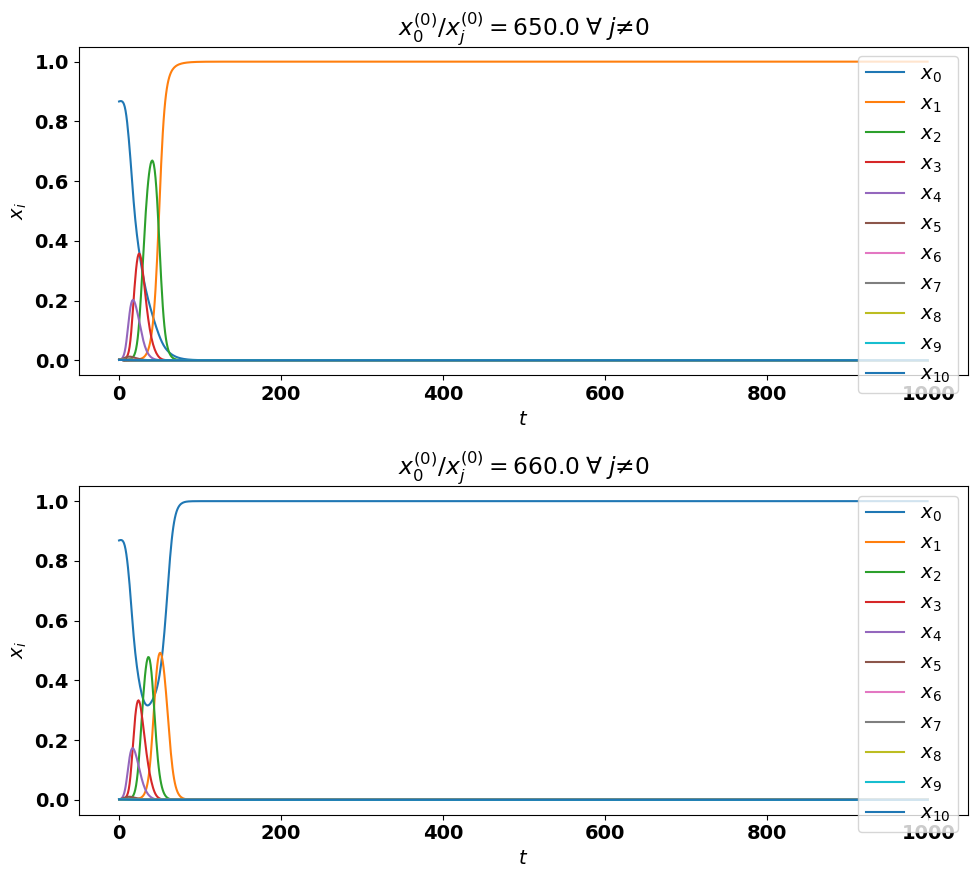

In [11]:
ts = np.linspace(0, 500, 1_000)


number_of_labelled_strategies = 11


initial_populations = []
for ratio in (650, 660):
    initial_x = np.ones(101)
    initial_x[0] = ratio
    initial_populations.append(initial_x / initial_x.sum())

fig, ax_array = plt.subplots(nrows=2, figsize=(10, 9))

for initial_x, ax in zip(initial_populations, ax_array):
    xs = scipy.integrate.odeint(func=get_derivative, y0=initial_x, t=ts)

    for i, x in enumerate(xs.T):
        if i < number_of_labelled_strategies:
            ax.plot(x, label=f"$x_{{{i}}}$")
        else:
            ax.plot(x)

    ax.set_xlabel("$t$")
    ax.set_ylabel("$x_i$")
    ax.set_title(f"$x_0^{{(0)}}/x_j^{{(0)}}={initial_x[0]/initial_x[1]}\;\\forall\;j\\ne0$")
    ax.legend()

fig.tight_layout();
fig.savefig("main.pdf", transparent=True)
